<a href="https://colab.research.google.com/github/smartdesignlab/SDL_teaching/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN (Generative Adversarial Networks)

- GAN : https://proceedings.neurips.cc/paper_files/paper/2014/file/5ca3e9b122f61f8f06494c97b1afccf3-Paper.pdf

## 1. Load dataset

In [1]:
!gdown --folder https://drive.google.com/drive/folders/12_pMH77NyqSnp8NY0EFzZn1dODgrx_p8?usp=drive_link
!unzip dataset/data_2000.zip -d ./data2000

Retrieving folder contents
Processing file 1T6zw4ggFfFlPQChqWia-VLKct1DTSLK6 data_500.zip
Processing file 1kHHoZPyk0_lCJYwqqaxd0hmBAdAxqEQY data_1000.zip
Processing file 12M-FQcVzzumCnhmFrzPkzeBoBZQtBSbj data_2000.zip
Processing file 1pNYu7bAEp8Lw08-VXMmHAgmEnJNhuhAF data_3000.zip
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1T6zw4ggFfFlPQChqWia-VLKct1DTSLK6
To: /content/dataset/data_500.zip
100% 567k/567k [00:00<00:00, 102MB/s]
Downloading...
From: https://drive.google.com/uc?id=1kHHoZPyk0_lCJYwqqaxd0hmBAdAxqEQY
To: /content/dataset/data_1000.zip
100% 1.20M/1.20M [00:00<00:00, 148MB/s]
Downloading...
From: https://drive.google.com/uc?id=12M-FQcVzzumCnhmFrzPkzeBoBZQtBSbj
To: /content/dataset/data_2000.zip
100% 2.27M/2.27M [00:00<00:00, 146MB/s]
Downloading...
From: https://drive.google.com/uc?id=1pNYu7bAEp8Lw08-VXMmHAgmEnJNhuhAF
To: /content/dataset/data_3000.zip
100% 3.31M/3

## 2. Import python libraries and define util functions

In [2]:
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader,TensorDataset
from torch.utils.data.dataset import random_split
from torchvision.utils import save_image
from torchsummary import summary

import scipy.io
from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# function to set seed
def set_seed(seed=42):
    # fix random seed
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    # CuDNN setup
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# function to read and display images
def img_read_plot(src,file):
    img = cv.imread(src+file,cv.COLOR_BGR2GRAY)  # convert the image to grayscale
    plt.imshow(img, cmap='gray')
    plt.xticks([])  # x axis
    plt.yticks([])  # y axis
    plt.show()  # display the image
    return img

# function to read images
def img_read(src,file):
    img = cv.imread(src+file,cv.COLOR_BGR2GRAY)  # convert the image to grayscale
    return img

In [3]:
set_seed(0)

## 3. Check dataset

In [4]:
path = './data2000/23.119.jpg'
from PIL import Image
img = Image.open(path)
img.show()
img_array = np.array(img)
print(img_array.shape)

(56, 56)


## 4. Convert images into trainable data

In [5]:
# image size = 56 x 56, 2000 images

# specify the below path to the unzipped data (ensure it ends with '/')
# you can change the file path if needed
src = './data2000/'

# loop through the files, read each image, and normalize it (-1 to 1)
def get_data():
    files = os.listdir(src)  # get the list of files in the source directory
    X = []  # initialize empty lists for storing images

    for file in files:
        X.append((img_read(src,file)-127.5)/127.5)  # normalize the data between -1 and 1

    # split the data into 80% training set and 20% test set (test set can be considered as validation)
    X_train, X_test = train_test_split(X, test_size=0.2, random_state=1,shuffle=True)

    # expand dimension to (batch_size, 1, height, width) in PyTorch
    X_train = np.expand_dims(X_train, axis=1)  # axis=1 for channel in PyTorch
    X_test = np.expand_dims(X_test, axis=1)  # same for test set

    return X_train, X_test

X_train, X_test = get_data()  # load data set (no y label needed as we only need images) / unsupervised learning

print("X_train.shape = {}".format(X_train.shape))
print("X_test.shape = {}".format(X_test.shape))

X_train.shape = (1600, 1, 56, 56)
X_test.shape = (400, 1, 56, 56)


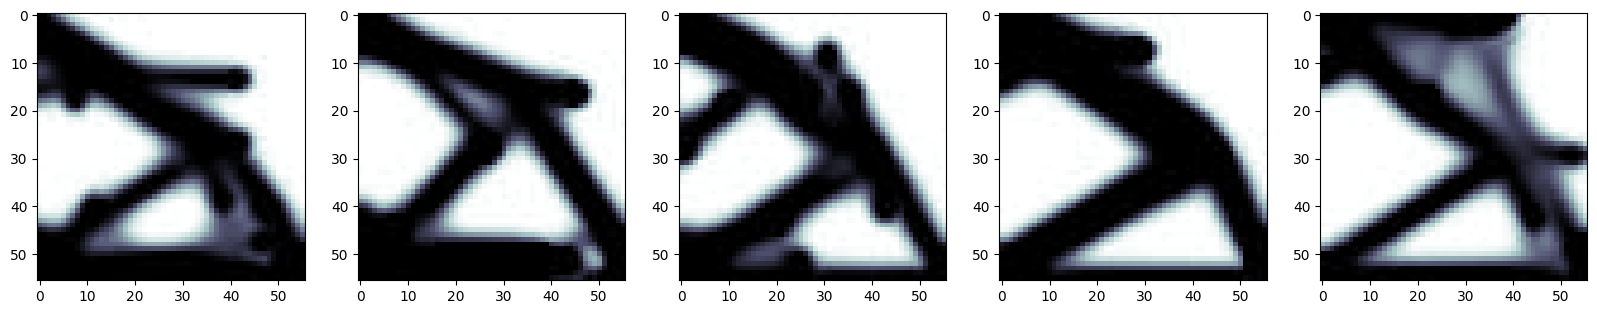

In [6]:
# display images
fig = plt.figure(figsize=(20,10))
nplot = 5

for i in range(1,nplot+1):
    ax = fig.add_subplot(1,nplot,i)
    ax.imshow(X_train[i, 0, :, :],cmap = plt.cm.bone)
plt.show()

## 5. Set to model architecture

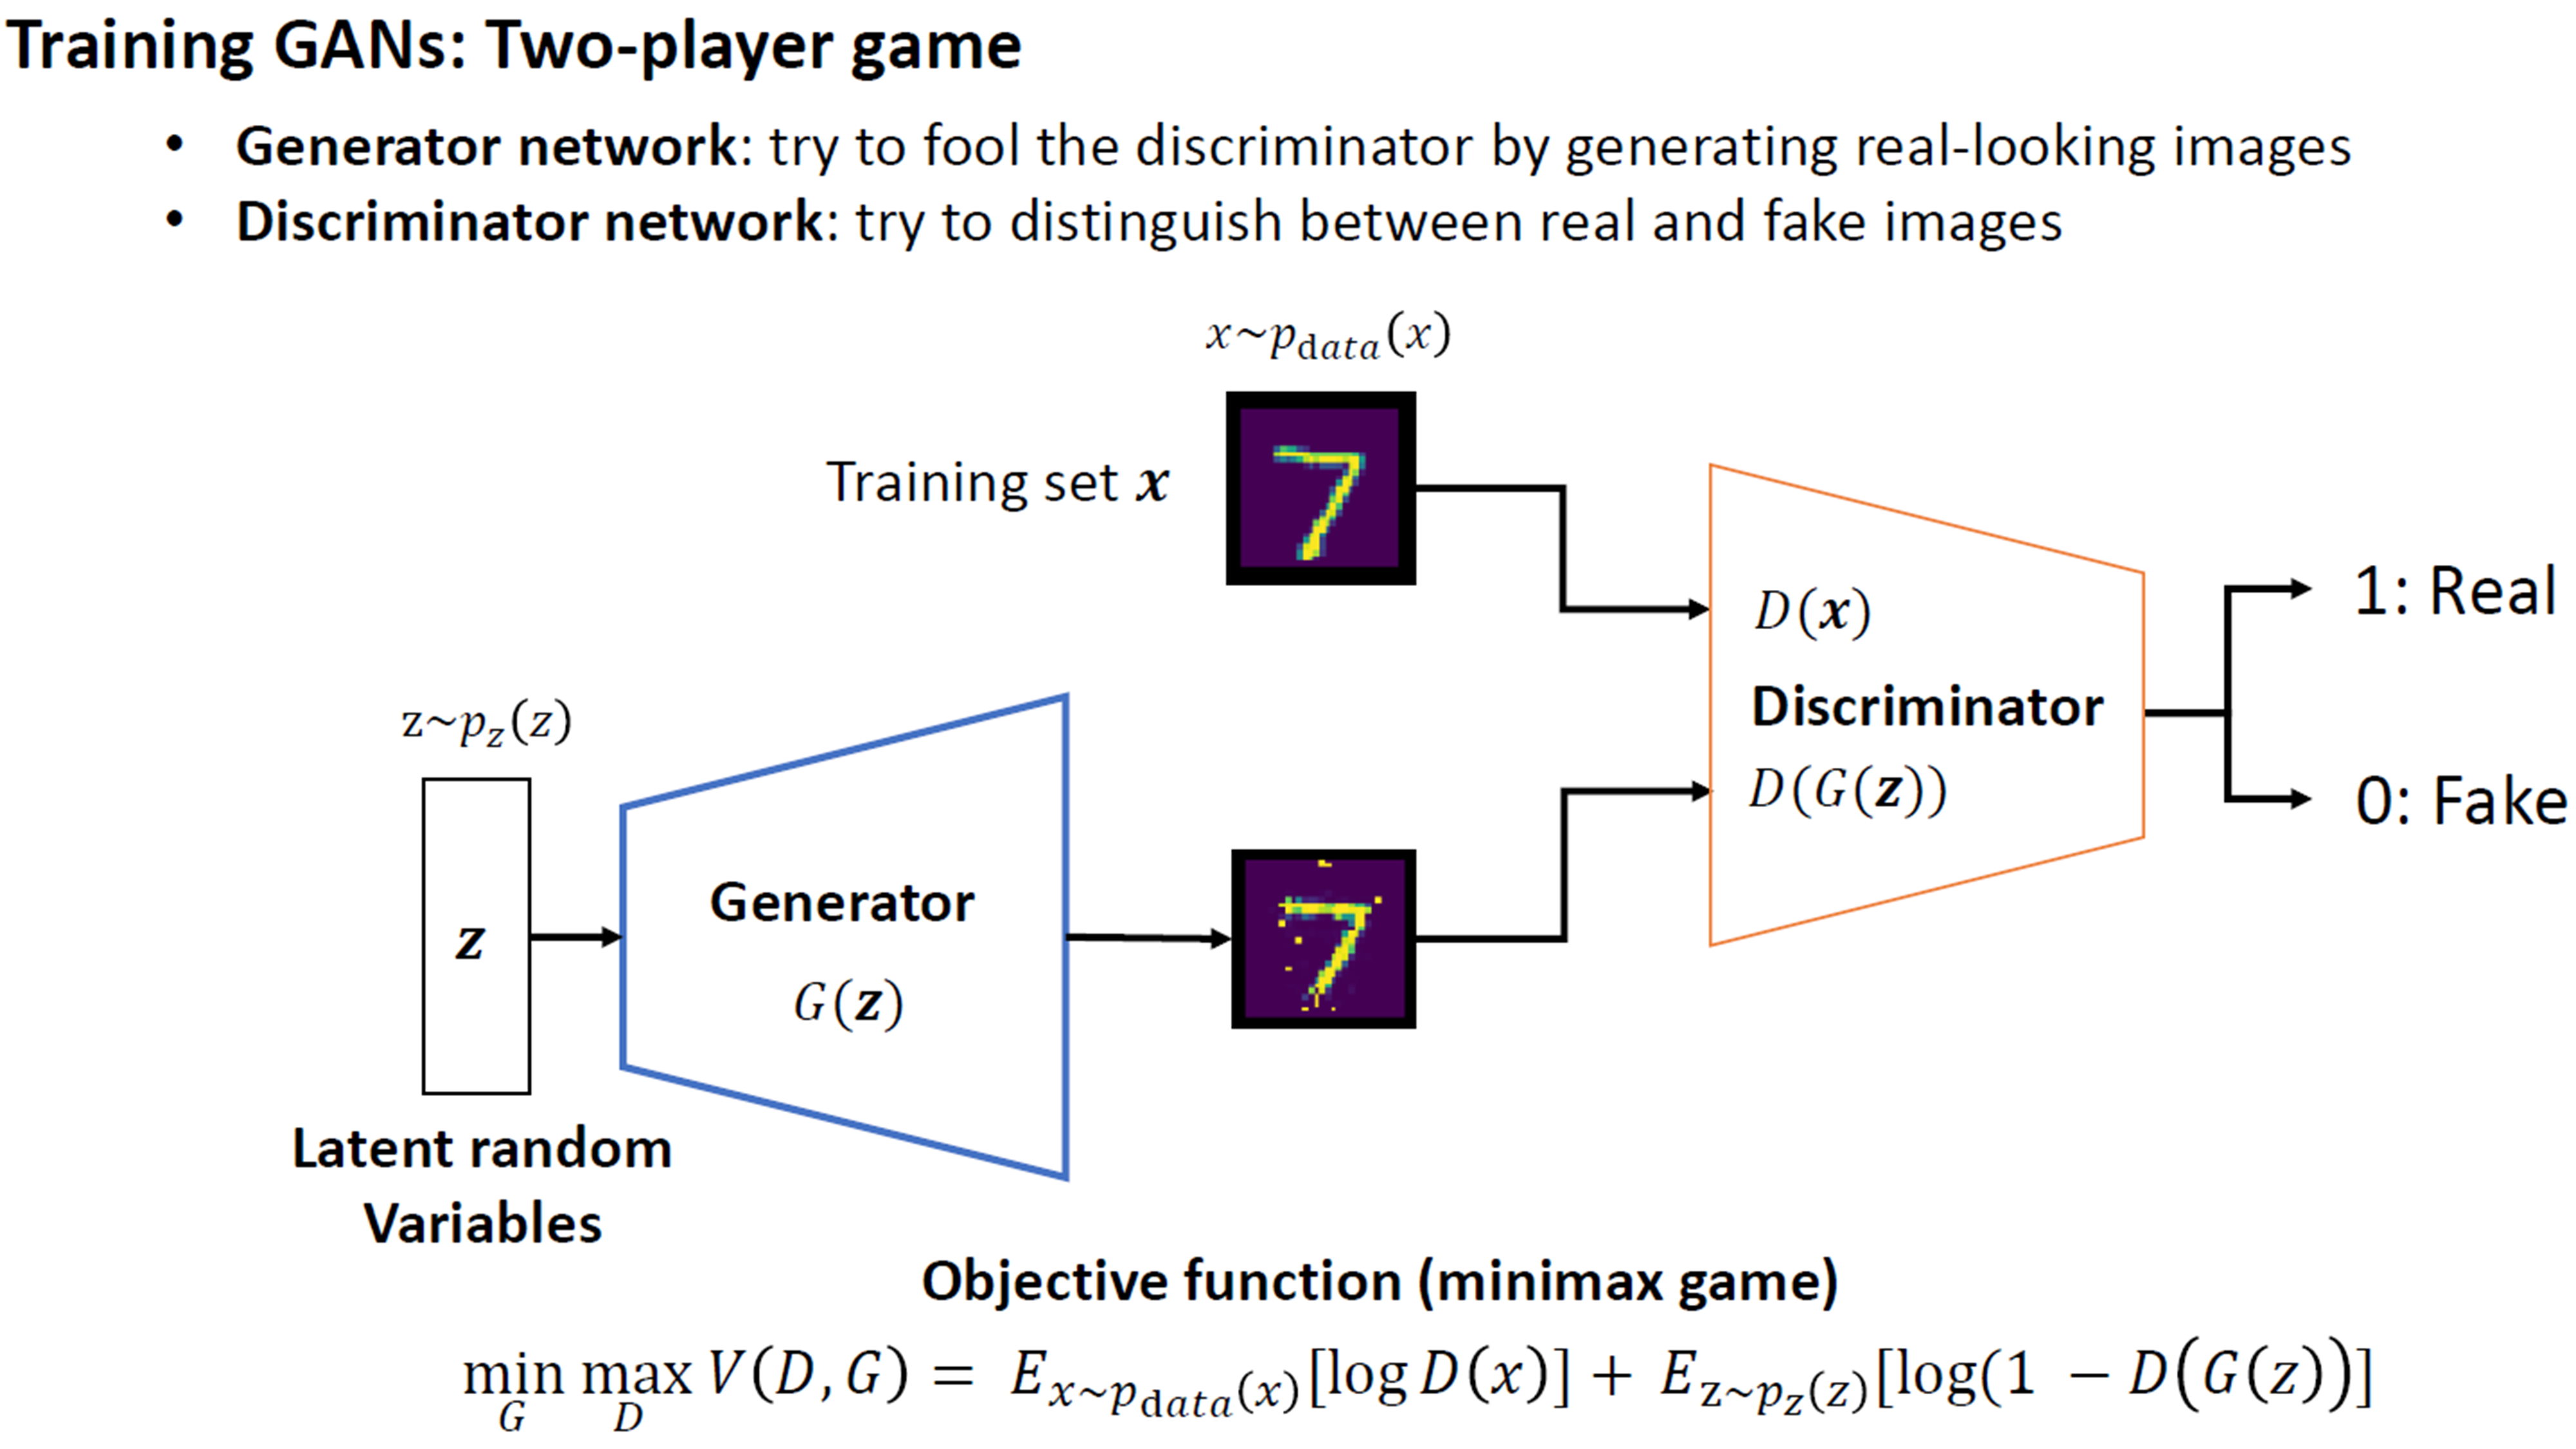

In [7]:
# ---------------------
#  Generator Network (input : noise >> output : image)
# ---------------------

class Generator(nn.Module):  # generate real-looking images
    def __init__(self):
        super(Generator, self).__init__()

        self.generator = nn.Sequential(
            nn.Linear(noise_size, hidden_size1),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size2, hidden_size3),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size3, img_size),
            nn.Tanh()  # output values in [-1, 1]
        )

    def forward(self, x):
        gen = self.generator(x)

        return gen

# ---------------------
#  Discriminator Network (input : image >> output : [1 / Real] or [0 / Fake])
# ---------------------

class Discriminator(nn.Module):  # distinguish between real and fake images
    def __init__(self):
        super(Discriminator, self).__init__()

        self.discriminator = nn.Sequential(
            nn.Linear(img_size, hidden_size3),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1),
            nn.Linear(hidden_size3, hidden_size2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1),
            nn.Linear(hidden_size2, hidden_size1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1),
            nn.Linear(hidden_size1, 1),
            nn.Sigmoid()  # output probability between [0, 1]
        )

    def forward(self, x):
        dis = self.discriminator(x)

        return dis

## 6. Set model hyperparameters

In [8]:
# model architecture parameters
hidden_size1 = 64
hidden_size2 = 256
hidden_size3 = 784
noise_size = 100

# training parameters
learning_rate = 0.0002
batch_size = 32
num_epoch = 200

# fixed values
img_size = 56 * 56              # image size
num_channel = 1                 # grayscale images
img_shape = (num_channel,56,56) # grayscale images

## 7. Train model

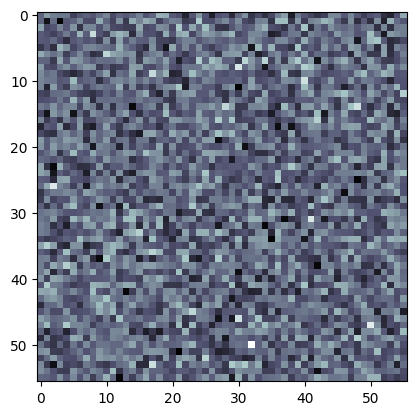

In [9]:
# define networks and set to device (GPU)
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# convert data to PyTorch tensors
train_images = torch.tensor(X_train, dtype=torch.float32).to(device)
test_images = torch.tensor(X_test, dtype=torch.float32).to(device)

# create DataLoader for training and validation data
train_dataset = TensorDataset(train_images)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# set to loss function & optimizer
criterion = nn.BCELoss() # binary cross entropy loss for binary classification
g_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)

# check generated fake bracket image
generated_image = generator(torch.randn([1, 100]).to(device)).cpu().detach()
plt.imshow(torch.reshape(generated_image, (56,56)), cmap=plt.cm.bone)

In [10]:
# define fixed noise for visualization
fixed_noise = torch.randn(10, noise_size).to(device)  # 10 fixed noise vectors

# create a directory to save generated images
os.makedirs("./GAN_samples/", exist_ok=True)

Epoch [1/200]  D Loss: 0.0550  G Loss: 3.0397


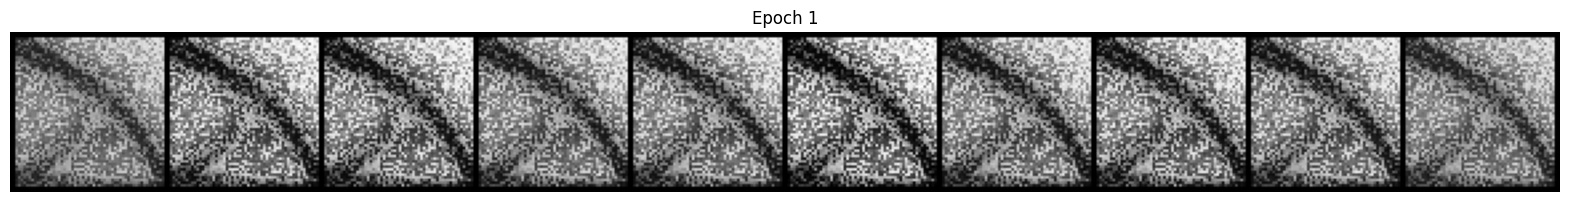

Epoch [2/200]  D Loss: 0.1189  G Loss: 2.4214
Epoch [3/200]  D Loss: 0.0685  G Loss: 2.2231
Epoch [4/200]  D Loss: 0.0139  G Loss: 4.2085
Epoch [5/200]  D Loss: 0.6888  G Loss: 0.2996
Epoch [6/200]  D Loss: 0.0997  G Loss: 2.2237
Epoch [7/200]  D Loss: 0.2521  G Loss: 2.4406
Epoch [8/200]  D Loss: 0.0178  G Loss: 4.2282
Epoch [9/200]  D Loss: 0.0349  G Loss: 7.3633
Epoch [10/200]  D Loss: 0.1061  G Loss: 2.0370
Epoch [11/200]  D Loss: 0.0548  G Loss: 3.5574
Epoch [12/200]  D Loss: 0.0077  G Loss: 4.7374
Epoch [13/200]  D Loss: 0.1128  G Loss: 2.4784
Epoch [14/200]  D Loss: 0.1750  G Loss: 4.3455
Epoch [15/200]  D Loss: 0.0422  G Loss: 6.8903
Epoch [16/200]  D Loss: 0.0224  G Loss: 5.7907
Epoch [17/200]  D Loss: 0.1160  G Loss: 2.8446
Epoch [18/200]  D Loss: 0.5695  G Loss: 4.9596
Epoch [19/200]  D Loss: 0.0572  G Loss: 3.8239
Epoch [20/200]  D Loss: 0.1395  G Loss: 3.8761


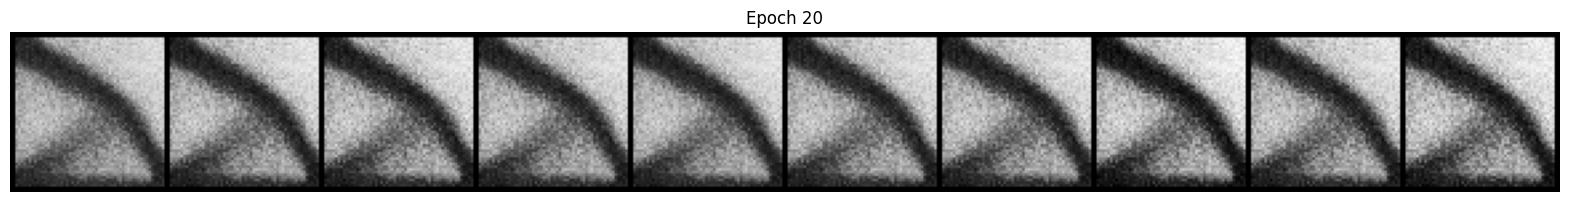

Epoch [21/200]  D Loss: 0.0040  G Loss: 5.6086
Epoch [22/200]  D Loss: 0.0117  G Loss: 4.6153
Epoch [23/200]  D Loss: 0.0017  G Loss: 7.1155
Epoch [24/200]  D Loss: 0.0623  G Loss: 4.6406
Epoch [25/200]  D Loss: 0.0454  G Loss: 3.8875
Epoch [26/200]  D Loss: 0.0110  G Loss: 5.4982
Epoch [27/200]  D Loss: 0.0169  G Loss: 4.3255
Epoch [28/200]  D Loss: 0.0256  G Loss: 4.0395
Epoch [29/200]  D Loss: 0.0162  G Loss: 5.4385
Epoch [30/200]  D Loss: 0.1886  G Loss: 4.0330
Epoch [31/200]  D Loss: 0.0065  G Loss: 5.0298
Epoch [32/200]  D Loss: 0.0016  G Loss: 7.9820
Epoch [33/200]  D Loss: 0.0505  G Loss: 3.2962
Epoch [34/200]  D Loss: 0.1084  G Loss: 6.3435
Epoch [35/200]  D Loss: 0.0056  G Loss: 5.7570
Epoch [36/200]  D Loss: 0.0005  G Loss: 7.3202
Epoch [37/200]  D Loss: 0.0247  G Loss: 3.3585
Epoch [38/200]  D Loss: 0.3500  G Loss: 1.4502
Epoch [39/200]  D Loss: 0.0756  G Loss: 8.1935
Epoch [40/200]  D Loss: 0.0370  G Loss: 4.4648


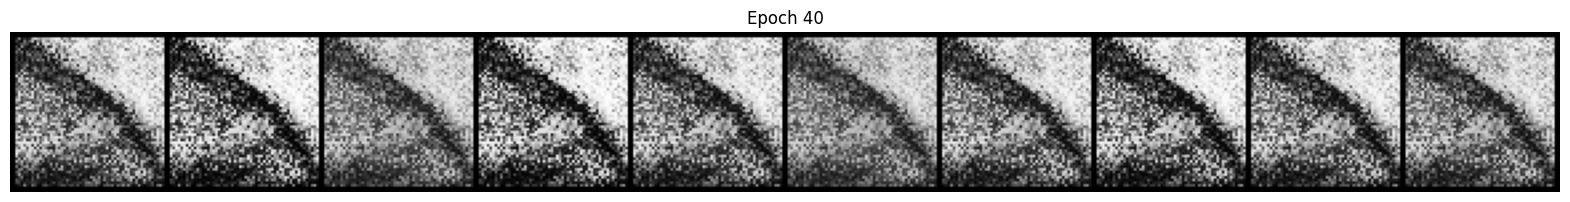

Epoch [41/200]  D Loss: 0.1863  G Loss: 5.0484
Epoch [42/200]  D Loss: 0.0270  G Loss: 5.6435
Epoch [43/200]  D Loss: 0.0016  G Loss: 10.7744
Epoch [44/200]  D Loss: 0.0269  G Loss: 6.8822
Epoch [45/200]  D Loss: 0.0250  G Loss: 4.1397
Epoch [46/200]  D Loss: 0.0207  G Loss: 5.4768
Epoch [47/200]  D Loss: 0.0288  G Loss: 6.3206
Epoch [48/200]  D Loss: 0.0308  G Loss: 4.6060
Epoch [49/200]  D Loss: 0.0041  G Loss: 5.8027
Epoch [50/200]  D Loss: 0.0020  G Loss: 6.1756
Epoch [51/200]  D Loss: 0.1112  G Loss: 3.6074
Epoch [52/200]  D Loss: 0.0044  G Loss: 6.0012
Epoch [53/200]  D Loss: 0.0044  G Loss: 5.3269
Epoch [54/200]  D Loss: 0.0314  G Loss: 9.5372
Epoch [55/200]  D Loss: 0.0593  G Loss: 2.7488
Epoch [56/200]  D Loss: 0.2444  G Loss: 5.8251
Epoch [57/200]  D Loss: 0.1413  G Loss: 8.3954
Epoch [58/200]  D Loss: 0.0233  G Loss: 4.0832
Epoch [59/200]  D Loss: 0.0477  G Loss: 4.1421
Epoch [60/200]  D Loss: 0.0082  G Loss: 6.1223


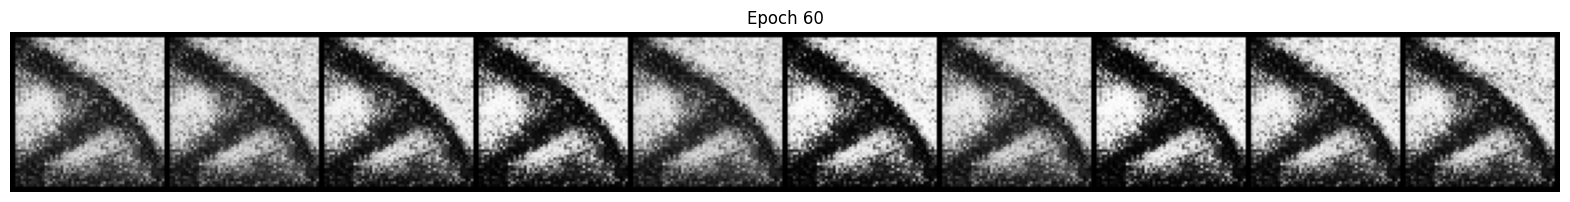

Epoch [61/200]  D Loss: 0.0000  G Loss: 12.8915
Epoch [62/200]  D Loss: 0.1182  G Loss: 3.2309
Epoch [63/200]  D Loss: 0.0181  G Loss: 5.5434
Epoch [64/200]  D Loss: 0.0234  G Loss: 4.1607
Epoch [65/200]  D Loss: 0.1161  G Loss: 8.9223
Epoch [66/200]  D Loss: 0.1167  G Loss: 5.7690
Epoch [67/200]  D Loss: 0.0068  G Loss: 5.4684
Epoch [68/200]  D Loss: 0.0154  G Loss: 10.4731
Epoch [69/200]  D Loss: 0.3482  G Loss: 7.1444
Epoch [70/200]  D Loss: 0.1167  G Loss: 4.3040
Epoch [71/200]  D Loss: 0.0272  G Loss: 5.6348
Epoch [72/200]  D Loss: 0.0158  G Loss: 8.8385
Epoch [73/200]  D Loss: 0.0106  G Loss: 5.1843
Epoch [74/200]  D Loss: 0.0765  G Loss: 4.6962
Epoch [75/200]  D Loss: 0.0161  G Loss: 4.8842
Epoch [76/200]  D Loss: 0.0336  G Loss: 4.0374
Epoch [77/200]  D Loss: 0.0140  G Loss: 6.4002
Epoch [78/200]  D Loss: 0.0006  G Loss: 7.6873
Epoch [79/200]  D Loss: 0.0188  G Loss: 6.0815
Epoch [80/200]  D Loss: 0.3207  G Loss: 4.3647


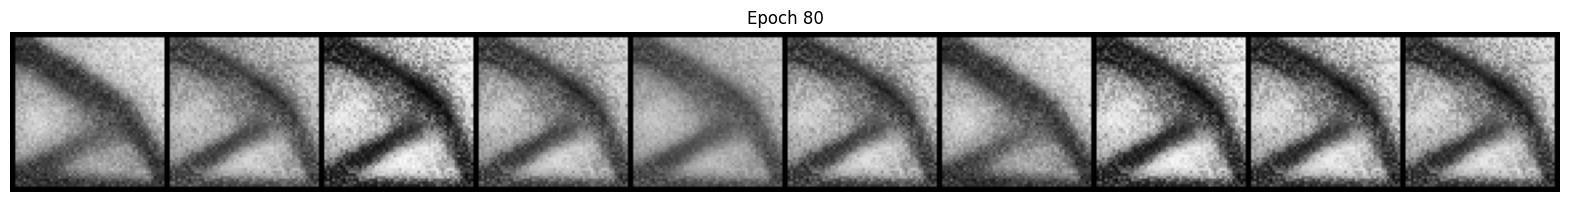

Epoch [81/200]  D Loss: 0.0234  G Loss: 3.6769
Epoch [82/200]  D Loss: 0.0401  G Loss: 3.0854
Epoch [83/200]  D Loss: 0.0067  G Loss: 4.8895
Epoch [84/200]  D Loss: 0.0373  G Loss: 4.5765
Epoch [85/200]  D Loss: 0.0638  G Loss: 3.0128
Epoch [86/200]  D Loss: 0.0373  G Loss: 3.2748
Epoch [87/200]  D Loss: 0.1172  G Loss: 2.1099
Epoch [88/200]  D Loss: 0.1291  G Loss: 3.5858
Epoch [89/200]  D Loss: 0.0501  G Loss: 5.9001
Epoch [90/200]  D Loss: 0.0129  G Loss: 6.4517
Epoch [91/200]  D Loss: 0.0264  G Loss: 5.8459
Epoch [92/200]  D Loss: 0.0306  G Loss: 8.0163
Epoch [93/200]  D Loss: 0.1171  G Loss: 5.8629
Epoch [94/200]  D Loss: 0.2501  G Loss: 3.2101
Epoch [95/200]  D Loss: 0.0226  G Loss: 4.2312
Epoch [96/200]  D Loss: 0.0880  G Loss: 6.0037
Epoch [97/200]  D Loss: 0.0972  G Loss: 12.5446
Epoch [98/200]  D Loss: 0.0152  G Loss: 4.8102
Epoch [99/200]  D Loss: 0.0115  G Loss: 6.2069
Epoch [100/200]  D Loss: 0.0194  G Loss: 4.3991


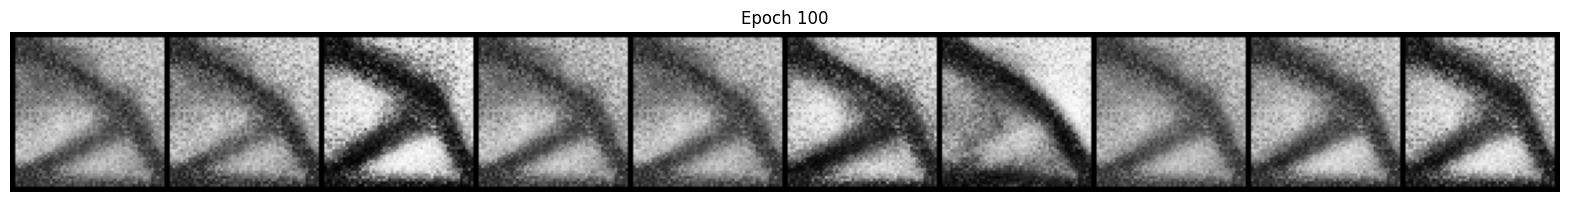

Epoch [101/200]  D Loss: 0.0183  G Loss: 6.1504
Epoch [102/200]  D Loss: 0.0141  G Loss: 6.8502
Epoch [103/200]  D Loss: 0.0256  G Loss: 4.8088
Epoch [104/200]  D Loss: 0.0653  G Loss: 5.2994
Epoch [105/200]  D Loss: 0.0222  G Loss: 6.5480
Epoch [106/200]  D Loss: 0.1137  G Loss: 4.6211
Epoch [107/200]  D Loss: 0.1032  G Loss: 3.7237
Epoch [108/200]  D Loss: 0.0463  G Loss: 4.2245
Epoch [109/200]  D Loss: 0.0885  G Loss: 4.8979
Epoch [110/200]  D Loss: 0.1219  G Loss: 6.4325
Epoch [111/200]  D Loss: 0.0362  G Loss: 3.5492
Epoch [112/200]  D Loss: 0.0557  G Loss: 3.7757
Epoch [113/200]  D Loss: 0.2223  G Loss: 6.4852
Epoch [114/200]  D Loss: 0.0449  G Loss: 4.9578
Epoch [115/200]  D Loss: 0.1333  G Loss: 4.4727
Epoch [116/200]  D Loss: 0.1021  G Loss: 4.6086
Epoch [117/200]  D Loss: 0.0961  G Loss: 3.6318
Epoch [118/200]  D Loss: 0.0754  G Loss: 4.8969
Epoch [119/200]  D Loss: 0.0466  G Loss: 3.9012
Epoch [120/200]  D Loss: 0.0967  G Loss: 3.7895


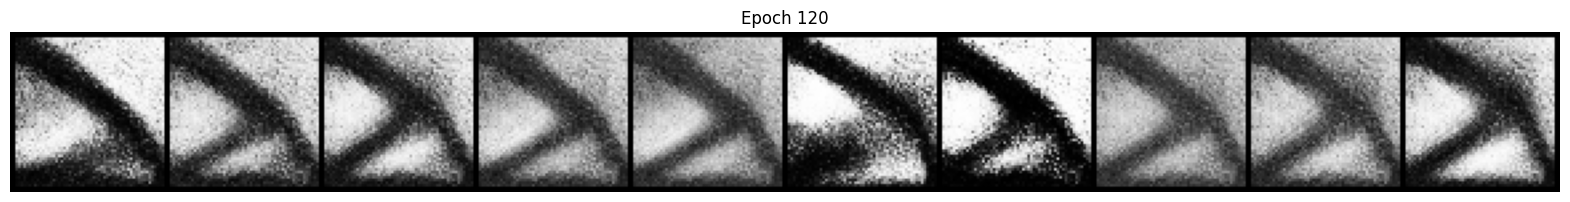

Epoch [121/200]  D Loss: 0.0767  G Loss: 6.3219
Epoch [122/200]  D Loss: 0.0783  G Loss: 6.0293
Epoch [123/200]  D Loss: 0.0376  G Loss: 4.1413
Epoch [124/200]  D Loss: 0.0525  G Loss: 4.6457
Epoch [125/200]  D Loss: 0.0617  G Loss: 5.5102
Epoch [126/200]  D Loss: 0.1740  G Loss: 5.2943
Epoch [127/200]  D Loss: 0.1462  G Loss: 2.7463
Epoch [128/200]  D Loss: 0.1054  G Loss: 4.0734
Epoch [129/200]  D Loss: 0.2911  G Loss: 4.1353
Epoch [130/200]  D Loss: 0.2688  G Loss: 3.8391
Epoch [131/200]  D Loss: 0.3130  G Loss: 4.8238
Epoch [132/200]  D Loss: 0.1229  G Loss: 5.2739
Epoch [133/200]  D Loss: 0.0703  G Loss: 4.1823
Epoch [134/200]  D Loss: 0.0171  G Loss: 4.4704
Epoch [135/200]  D Loss: 0.0593  G Loss: 4.4412
Epoch [136/200]  D Loss: 0.0872  G Loss: 4.8958
Epoch [137/200]  D Loss: 0.0514  G Loss: 3.7429
Epoch [138/200]  D Loss: 0.3729  G Loss: 2.7692
Epoch [139/200]  D Loss: 0.2311  G Loss: 3.7496
Epoch [140/200]  D Loss: 0.0733  G Loss: 4.4269


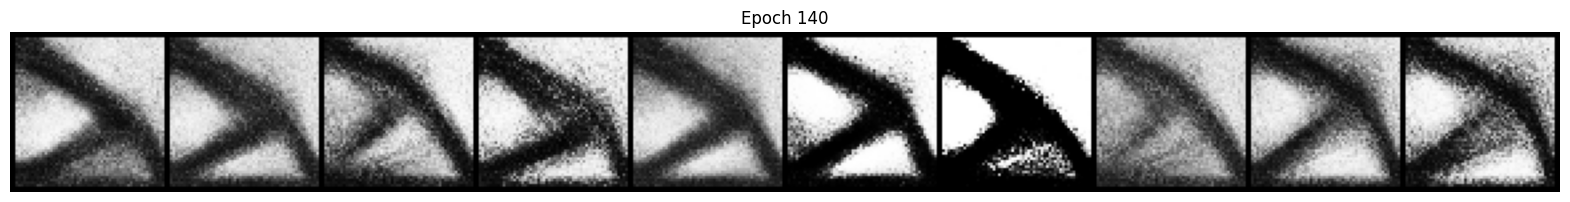

Epoch [141/200]  D Loss: 0.0625  G Loss: 5.8406
Epoch [142/200]  D Loss: 0.0677  G Loss: 4.3263
Epoch [143/200]  D Loss: 0.1223  G Loss: 5.1545
Epoch [144/200]  D Loss: 0.0332  G Loss: 4.0307
Epoch [145/200]  D Loss: 0.1038  G Loss: 2.6901
Epoch [146/200]  D Loss: 0.0565  G Loss: 7.0740
Epoch [147/200]  D Loss: 0.2339  G Loss: 3.4688
Epoch [148/200]  D Loss: 0.1253  G Loss: 2.7369
Epoch [149/200]  D Loss: 0.0103  G Loss: 6.2139
Epoch [150/200]  D Loss: 0.0273  G Loss: 5.4758
Epoch [151/200]  D Loss: 0.1185  G Loss: 6.2386
Epoch [152/200]  D Loss: 0.0249  G Loss: 5.0307
Epoch [153/200]  D Loss: 0.0823  G Loss: 5.0108
Epoch [154/200]  D Loss: 0.2267  G Loss: 4.0566
Epoch [155/200]  D Loss: 0.1091  G Loss: 6.5338
Epoch [156/200]  D Loss: 0.0895  G Loss: 3.2470
Epoch [157/200]  D Loss: 0.1125  G Loss: 4.3103
Epoch [158/200]  D Loss: 0.1694  G Loss: 3.1100
Epoch [159/200]  D Loss: 0.1149  G Loss: 2.9160
Epoch [160/200]  D Loss: 0.0278  G Loss: 4.4345


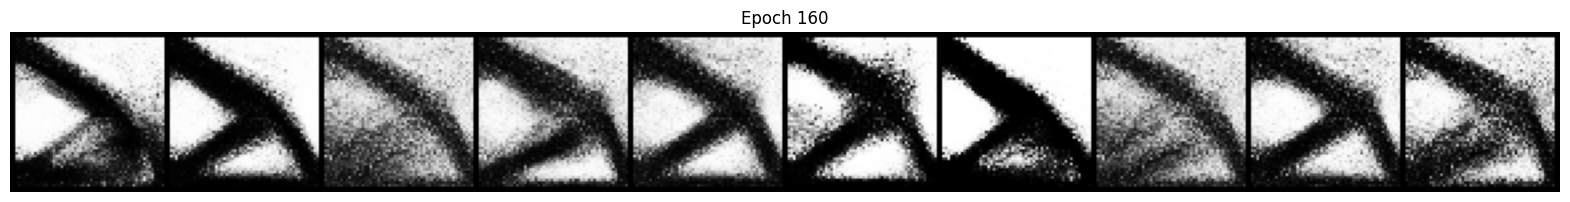

Epoch [161/200]  D Loss: 0.0849  G Loss: 2.8495
Epoch [162/200]  D Loss: 0.0302  G Loss: 4.6090
Epoch [163/200]  D Loss: 0.1045  G Loss: 3.2620
Epoch [164/200]  D Loss: 0.0424  G Loss: 3.6090
Epoch [165/200]  D Loss: 0.2022  G Loss: 4.9825
Epoch [166/200]  D Loss: 0.0826  G Loss: 3.6828
Epoch [167/200]  D Loss: 0.2064  G Loss: 5.6746
Epoch [168/200]  D Loss: 0.0602  G Loss: 3.4817
Epoch [169/200]  D Loss: 0.1663  G Loss: 3.3123
Epoch [170/200]  D Loss: 0.0297  G Loss: 3.8569
Epoch [171/200]  D Loss: 0.0462  G Loss: 5.3274
Epoch [172/200]  D Loss: 0.1182  G Loss: 2.7257
Epoch [173/200]  D Loss: 0.1461  G Loss: 4.5085
Epoch [174/200]  D Loss: 0.0924  G Loss: 4.4084
Epoch [175/200]  D Loss: 0.0343  G Loss: 5.2680
Epoch [176/200]  D Loss: 0.1623  G Loss: 4.4870
Epoch [177/200]  D Loss: 0.1258  G Loss: 3.3931
Epoch [178/200]  D Loss: 0.0504  G Loss: 4.7602
Epoch [179/200]  D Loss: 0.1413  G Loss: 4.4427
Epoch [180/200]  D Loss: 0.1650  G Loss: 5.9983


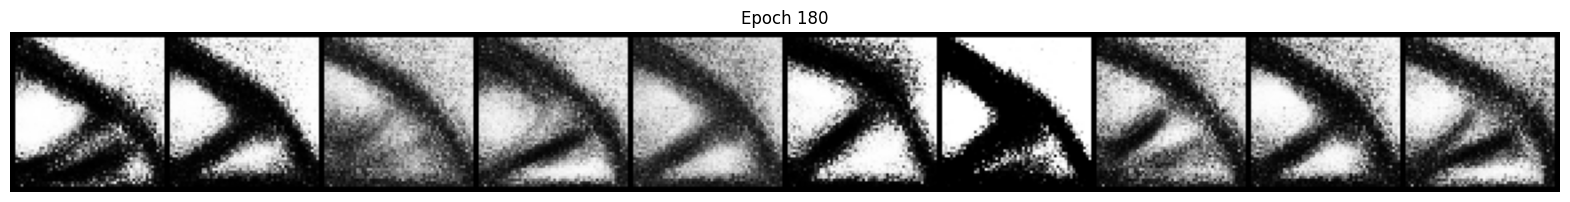

Epoch [181/200]  D Loss: 0.1348  G Loss: 4.4559
Epoch [182/200]  D Loss: 0.1763  G Loss: 5.5179
Epoch [183/200]  D Loss: 0.0222  G Loss: 6.7446
Epoch [184/200]  D Loss: 0.0496  G Loss: 3.2638
Epoch [185/200]  D Loss: 0.1068  G Loss: 3.4230
Epoch [186/200]  D Loss: 0.1434  G Loss: 3.2230
Epoch [187/200]  D Loss: 0.2715  G Loss: 3.7115
Epoch [188/200]  D Loss: 0.0397  G Loss: 4.8330
Epoch [189/200]  D Loss: 0.2907  G Loss: 5.9361
Epoch [190/200]  D Loss: 0.0860  G Loss: 3.7477
Epoch [191/200]  D Loss: 0.1845  G Loss: 3.7600
Epoch [192/200]  D Loss: 0.1354  G Loss: 2.1895
Epoch [193/200]  D Loss: 0.1801  G Loss: 5.0606
Epoch [194/200]  D Loss: 0.1643  G Loss: 3.7229
Epoch [195/200]  D Loss: 0.0502  G Loss: 4.5768
Epoch [196/200]  D Loss: 0.1295  G Loss: 3.3997
Epoch [197/200]  D Loss: 0.0434  G Loss: 5.7063
Epoch [198/200]  D Loss: 0.1060  G Loss: 3.7604
Epoch [199/200]  D Loss: 0.1978  G Loss: 5.7363
Epoch [200/200]  D Loss: 0.1741  G Loss: 4.9601


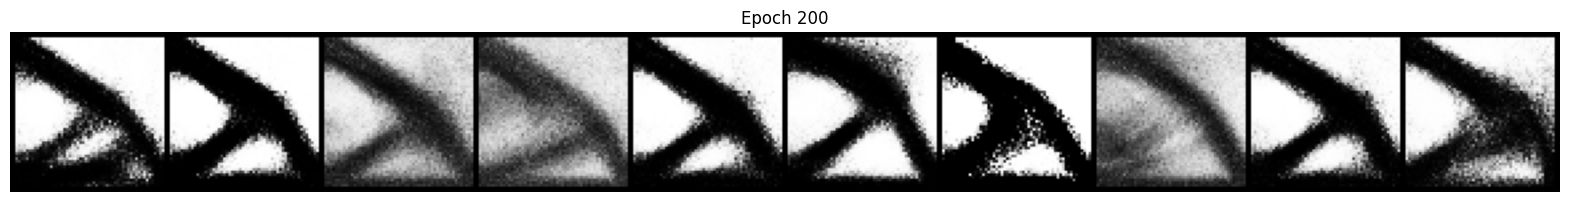

In [11]:
"""
Training part
"""
for epoch in range(1, num_epoch + 1):

    for i, (images) in enumerate(train_loader):

        # make ground truth (labels) -> [1 / Real] & [0 / Fake]
        real_label = torch.full((batch_size, 1), 1, dtype=torch.float32).to(device)
        fake_label = torch.full((batch_size, 1), 0, dtype=torch.float32).to(device)

        # reshape real images --> flatten to (batch_size, 56*56)
        real_images = images[0].reshape(batch_size, -1)  # flatten image to (batch_size, 56*56)

        # +---------------------+
        # |   train Generator   |
        # +---------------------+

        # initialize gradient -> initialize generator model gradient to 0
        g_optimizer.zero_grad()

        # make fake images with generator & noise vector 'z'
        z = torch.randn(batch_size, noise_size).to(device)
        fake_images = generator(z)

        # compare result of discriminator with fake images & real labels
        # if generator deceives discriminator, g_loss will decrease
        g_loss = criterion(discriminator(fake_images), real_label)

        # train generator with backpropagation
        g_loss.backward()
        g_optimizer.step()

        # +---------------------+
        # | train Discriminator |
        # +---------------------+

        # initialize gradient -> initialize discriminator model gradient to 0
        d_optimizer.zero_grad()

        # calculate fake & real loss with generated images above & real images
        fake_loss = criterion(discriminator(fake_images.detach()), fake_label)
        real_loss = criterion(discriminator(real_images), real_label)
        d_loss = (fake_loss + real_loss)/2

        # train discriminator with backpropagation
        d_loss.backward()
        d_optimizer.step()

    # print losses at the end of each epoch
    print(f"Epoch [{epoch}/{num_epoch}]  D Loss: {d_loss.item():.4f}  G Loss: {g_loss.item():.4f}")

    # save and visualize generated images at specific intervals
    if epoch % 20 == 0 or epoch == 1:
        with torch.no_grad():
            # generate fake images with fixed noise
            fake_images = generator(fixed_noise).detach().cpu()
        fake_images = fake_images.view(-1, 1, 56, 56)

        # save images as a grid using save_image
        save_image(fake_images, f"./GAN_samples/GAN_epoch_{epoch}.png", nrow=10, normalize=True)

        # display the generated images
        plt.figure(figsize=(20, 4))
        img = plt.imread(f"./GAN_samples/GAN_epoch_{epoch}.png")
        plt.imshow(img)
        plt.title(f"Epoch {epoch}")
        plt.axis('off')
        plt.show()

        # optionally, save model checkpoints
        if epoch % 50 == 0 or epoch == num_epoch:
            torch.save(generator.state_dict(), f"./GAN_samples/generator_epoch_{epoch}.pth")
            torch.save(discriminator.state_dict(), f"./GAN_samples/discriminator_epoch_{epoch}.pth")



## 8. Load & Evaluate model

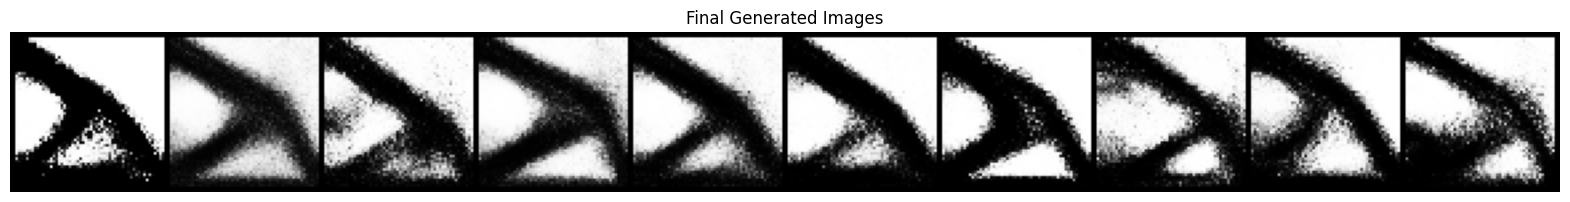

In [13]:
# final Image Generation and Visualization after training
with torch.no_grad():
    final_noise = torch.randn(10, noise_size).to(device)
    final_fake_images = generator(final_noise).cpu()
    final_fake_images = final_fake_images.view(-1, 1, 56, 56)
    save_image(final_fake_images, f"./GAN_samples/GAN_final.png", nrow=10, normalize=True)

# display the final generated images
plt.figure(figsize=(20, 4))
img = plt.imread("./GAN_samples/GAN_final.png")
plt.imshow(img)
plt.title("Final Generated Images")
plt.axis('off')
plt.show()